In [626]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation
from sklearn.linear_model import LogisticRegression # Linear Regression Model
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix #model evaluation
from sklearn.cluster import KMeans # k-means
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split

In [627]:
df = pd.read_csv('data/SubscriberInformation.csv')
df.head()

,ID,Language,Subscription Type,Subscription Event Type,Purchase Store,Purchase Amount,Currency,Subscription Start Date,Subscription Expiration,Demo User,...,User Type,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count,USDAdjusted
0,1,POR,Limited,INITIAL_PURCHASE,App,NaN,NaN,12/28/2018,6/28/2019,Yes,...,Consumer,App,Yes,Yes,63.0,7.0,0.0,6.0,0.0,0
1,2,EBR,Limited,INITIAL_PURCHASE,Web,39.0,USD,11/28/2019,2/28/2020,No,...,Consumer,Web,No,Yes,4.0,3.0,0.0,1.0,0.0,39
2,3,ESP,Limited,INITIAL_PURCHASE,Web,0.0,USD,12/31/2018,12/31/2019,No,...,Consumer,Web,Yes,Yes,1.0,0.0,0.0,0.0,0.0,0
3,4,KOR,Limited,INITIAL_PURCHASE,App,NaN,NaN,11/7/2019,2/7/2020,Yes,...,Consumer,App,Yes,Yes,14.0,0.0,0.0,0.0,0.0,NaN
4,5,ENG,Limited,INITIAL_PURCHASE,App,NaN,NaN,8/13/2019,11/13/2019,No,...,Consumer,Web,Yes,Yes,80.0,5.0,1.0,5.0,1.0,NaN


# Cleaning Data

In [628]:
df.shape

(40102, 25)

In [629]:
np.sum(df.isnull())

ID                             0
Language                       0
Subscription Type              0
Subscription Event Type        0
Purchase Store                 0
Purchase Amount            13179
Currency                   13178
Subscription Start Date        0
Subscription Expiration        0
Demo User                      0
Free Trial User                0
Free Trial Start Date      34269
Free Trial Expiration      34269
Auto Renew                     1
Country                        0
User Type                      0
Lead Platform                  0
Email Subscriber               0
Push Notifications             0
Send Count                 11654
Open Count                 11654
Click Count                11654
Unique Open Count          11654
Unique Click Count         11654
USDAdjusted                13177
dtype: int64

In [630]:
df.drop(['ID','Free Trial Start Date', 'Free Trial Expiration', 'User Type', 'Purchase Amount', 'Currency', 'Subscription Type', 'Unique Open Count', 'Unique Click Count'], axis='columns', inplace = True)

#Dropping 0 values for purchase amount (USD adjusted)
for i in range(len(df)):
    if df['USDAdjusted'].iloc[i] == '#VALUE!':
        df['USDAdjusted'].iloc[i] = 0
        
df.shape

(40102, 16)

In [631]:
df['USDAdjusted'] = df['USDAdjusted'].astype(float)
df = df[df.USDAdjusted != 0]

df.shape

(33062, 16)

In [632]:
df.dropna(inplace = True)
df.reset_index()

,index,Language,Subscription Event Type,Purchase Store,Subscription Start Date,Subscription Expiration,Demo User,Free Trial User,Auto Renew,Country,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,USDAdjusted
0,1,EBR,INITIAL_PURCHASE,Web,11/28/2019,2/28/2020,No,No,Off,Other,Web,No,Yes,4.0,3.0,0.0,39.000000
1,5,ESP,INITIAL_PURCHASE,Web,8/23/2019,11/23/2019,Yes,No,Off,US/Canada,App,Yes,Yes,162.0,1.0,0.0,38.340000
2,6,ESP,RENEWAL,Web,7/21/2019,11/11/2019,Yes,No,Off,Other,App,Yes,Yes,2.0,0.0,0.0,79.000000
3,7,DEU,INITIAL_PURCHASE,Web,3/7/2020,6/7/2020,Yes,No,On,US/Canada,App,Yes,Yes,25.0,17.0,4.0,38.400000
4,8,DEU,INITIAL_PURCHASE,Web,3/3/2020,6/8/2020,No,Yes,On,Europe,Web,No,Yes,52.0,11.0,0.0,43.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14964,40092,ESP,INITIAL_PURCHASE,Web,3/10/2020,6/10/2020,No,No,On,Other,Unknown,No,No,16.0,10.0,0.0,35.970000
14965,40093,ESP,RENEWAL,Web,12/24/2019,6/24/2020,No,No,On,Other,Unknown,No,No,4.0,0.0,0.0,35.970000
14966,40094,KOR,INITIAL_PURCHASE,Web,1/12/2019,2/12/2019,No,No,Off,Europe,Web,Yes,Yes,40.0,0.0,0.0,12.394300
14967,40095,ALL,INITIAL_PURCHASE,Web,3/15/2020,1/1/2099,No,No,Off,Other,Unknown,No,No,6.0,2.0,0.0,212.130000


### Replacing yes/no variables with 1 and 0

In [633]:
for i in range(len(df)):
    if df['Push Notifications'].iloc[i] == 'Yes':
        df['Push Notifications'].iloc[i] = 1
    else:
        df['Push Notifications'].iloc[i] = 0
    if df['Email Subscriber'].iloc[i] == 'Yes':
        df['Email Subscriber'].iloc[i] = 1
    else:
        df['Email Subscriber'].iloc[i] = 0
    if df['Free Trial User'].iloc[i] == 'Yes':
        df['Free Trial User'].iloc[i] = 1
    else:
        df['Free Trial User'].iloc[i] = 0
    if df['Demo User'].iloc[i] == 'Yes':
        df['Demo User'].iloc[i] = 1
    else:
        df['Demo User'].iloc[i] = 0
    if df['Lead Platform'].iloc[i] == 'App':
        df['Lead Platform'].iloc[i] = 1
    else:
        df['Lead Platform'].iloc[i] = 0
    if df['Auto Renew'].iloc[i] == 'On':
        df['Auto Renew'].iloc[i] = 1
    else:
        df['Auto Renew'].iloc[i] = 0
    if df['Purchase Store'].iloc[i] == 'App':
        df['Purchase Store'].iloc[i] = 1
    else:
        df['Purchase Store'].iloc[i] = 0
        
df.reset_index()

,index,Language,Subscription Event Type,Purchase Store,Subscription Start Date,Subscription Expiration,Demo User,Free Trial User,Auto Renew,Country,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,USDAdjusted
0,1,EBR,INITIAL_PURCHASE,0,11/28/2019,2/28/2020,0,0,0,Other,0,0,1,4.0,3.0,0.0,39.000000
1,5,ESP,INITIAL_PURCHASE,0,8/23/2019,11/23/2019,1,0,0,US/Canada,1,1,1,162.0,1.0,0.0,38.340000
2,6,ESP,RENEWAL,0,7/21/2019,11/11/2019,1,0,0,Other,1,1,1,2.0,0.0,0.0,79.000000
3,7,DEU,INITIAL_PURCHASE,0,3/7/2020,6/7/2020,1,0,1,US/Canada,1,1,1,25.0,17.0,4.0,38.400000
4,8,DEU,INITIAL_PURCHASE,0,3/3/2020,6/8/2020,0,1,1,Europe,0,0,1,52.0,11.0,0.0,43.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14964,40092,ESP,INITIAL_PURCHASE,0,3/10/2020,6/10/2020,0,0,1,Other,0,0,0,16.0,10.0,0.0,35.970000
14965,40093,ESP,RENEWAL,0,12/24/2019,6/24/2020,0,0,1,Other,0,0,0,4.0,0.0,0.0,35.970000
14966,40094,KOR,INITIAL_PURCHASE,0,1/12/2019,2/12/2019,0,0,0,Europe,0,1,1,40.0,0.0,0.0,12.394300
14967,40095,ALL,INITIAL_PURCHASE,0,3/15/2020,1/1/2099,0,0,0,Other,0,0,0,6.0,2.0,0.0,212.130000


### Creating Subscription Length (Days)

In [634]:
import datetime

df['Subscription Length (days)'] = 0

day = 86400

for i in range(len(df)):
    
    start = df['Subscription Start Date'].iloc[i]
    end = df['Subscription Expiration'].iloc[i]


    startList = start.split('/')
    endList = end.split('/')


    start_epoch = int(datetime.datetime(int(startList[2]),int(startList[0]),int(startList[1]),0,0).strftime('%s'))
    end_epoch = int(datetime.datetime(int(endList[2]),int(endList[0]),int(endList[1]),0,0).strftime('%s'))

    sub_length = end_epoch - start_epoch
    sub_length = sub_length / day
    df['Subscription Length (days)'].iloc[i] = round(sub_length, 0)
    
df.drop(['Subscription Start Date','Subscription Expiration'], axis='columns', inplace = True)
df

,Language,Subscription Event Type,Purchase Store,Demo User,Free Trial User,Auto Renew,Country,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,USDAdjusted,Subscription Length (days)
1,EBR,INITIAL_PURCHASE,0,0,0,0,Other,0,0,1,4.0,3.0,0.0,39.000000,92.0
5,ESP,INITIAL_PURCHASE,0,1,0,0,US/Canada,1,1,1,162.0,1.0,0.0,38.340000,92.0
6,ESP,RENEWAL,0,1,0,0,Other,1,1,1,2.0,0.0,0.0,79.000000,113.0
7,DEU,INITIAL_PURCHASE,0,1,0,1,US/Canada,1,1,1,25.0,17.0,4.0,38.400000,92.0
8,DEU,INITIAL_PURCHASE,0,0,1,1,Europe,0,0,1,52.0,11.0,0.0,43.160000,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40092,ESP,INITIAL_PURCHASE,0,0,0,1,Other,0,0,0,16.0,10.0,0.0,35.970000,92.0
40093,ESP,RENEWAL,0,0,0,1,Other,0,0,0,4.0,0.0,0.0,35.970000,183.0
40094,KOR,INITIAL_PURCHASE,0,0,0,0,Europe,0,1,1,40.0,0.0,0.0,12.394300,31.0
40095,ALL,INITIAL_PURCHASE,0,0,0,0,Other,0,0,0,6.0,2.0,0.0,212.130000,28781.0


# Exploring Data

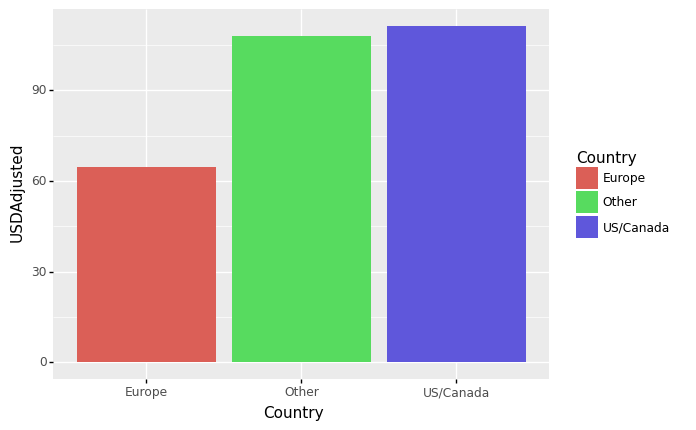

<ggplot: (8790373821675)>

In [588]:
ggplot(df, aes(x = 'Country', y = 'USDAdjusted', fill = 'Country')) + stat_summary(geom = "bar")

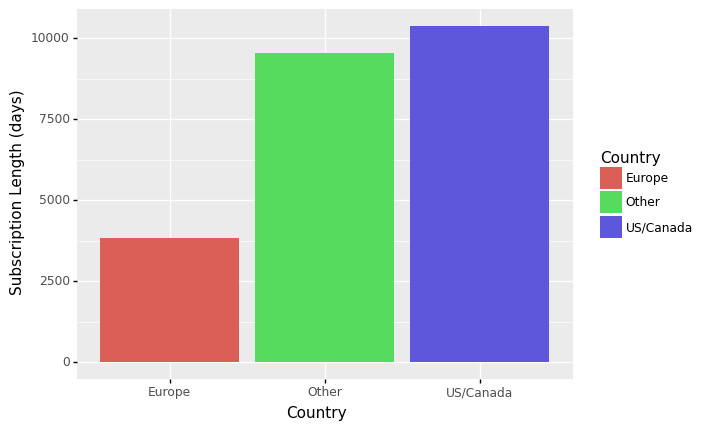

<ggplot: (8790395831345)>

In [589]:
ggplot(df, aes(x = 'Country', y = 'Subscription Length (days)', fill = 'Country')) + stat_summary(geom = "bar")

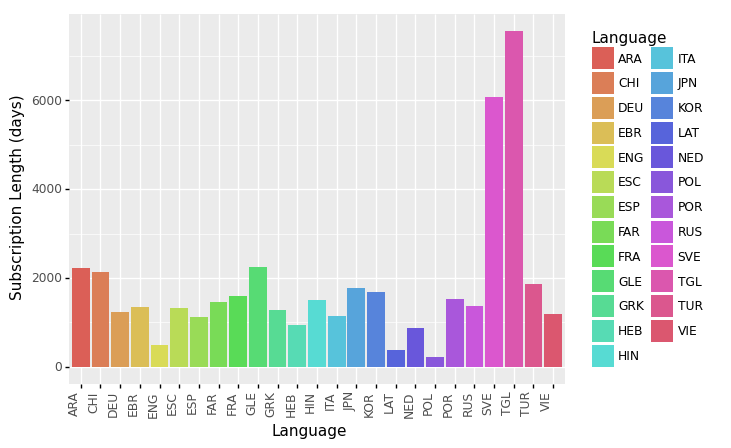

<ggplot: (8790374367392)>

In [590]:
l_df = df[df.Language != 'ALL']

ggplot(l_df, aes(x = 'Language', y = 'Subscription Length (days)', fill = 'Language')) + stat_summary(geom = "bar") + theme(axis_text_x=element_text(rotation=90, hjust=1))


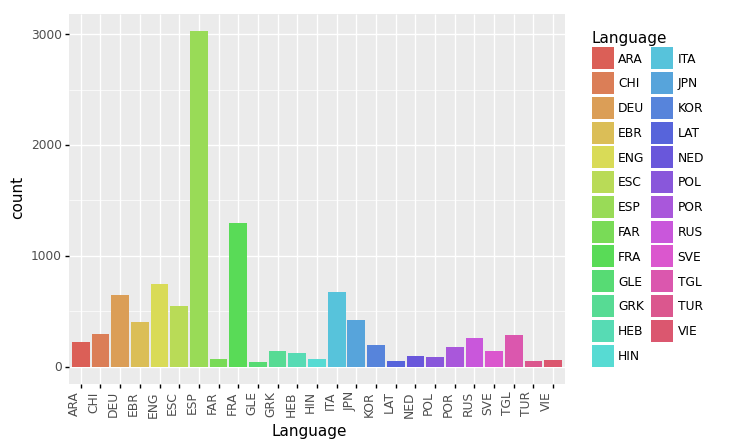

<ggplot: (8790396366156)>

In [591]:
l_df = df[df.Language != 'ALL']

ggplot(l_df, aes(x = 'Language', fill = 'Language')) + geom_bar() + theme(axis_text_x=element_text(rotation=90, hjust=1))

### Adding dummy variables

In [592]:
#Adding dummy variables for modeling
df = pd.get_dummies(df, columns = ['Subscription Event Type', 'Country'])
df

,Language,Purchase Store,Demo User,Free Trial User,Auto Renew,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,USDAdjusted,Subscription Length (days),Subscription Event Type_INITIAL_PURCHASE,Subscription Event Type_RENEWAL,Country_Europe,Country_Other,Country_US/Canada
1,EBR,0,0,0,0,0,0,1,4.0,3.0,0.0,39.000000,92.0,1,0,0,1,0
5,ESP,0,1,0,0,1,1,1,162.0,1.0,0.0,38.340000,92.0,1,0,0,0,1
6,ESP,0,1,0,0,1,1,1,2.0,0.0,0.0,79.000000,113.0,0,1,0,1,0
7,DEU,0,1,0,1,1,1,1,25.0,17.0,4.0,38.400000,92.0,1,0,0,0,1
8,DEU,0,0,1,1,0,0,1,52.0,11.0,0.0,43.160000,97.0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40092,ESP,0,0,0,1,0,0,0,16.0,10.0,0.0,35.970000,92.0,1,0,0,1,0
40093,ESP,0,0,0,1,0,0,0,4.0,0.0,0.0,35.970000,183.0,0,1,0,1,0
40094,KOR,0,0,0,0,0,1,1,40.0,0.0,0.0,12.394300,31.0,1,0,1,0,0
40095,ALL,0,0,0,0,0,0,0,6.0,2.0,0.0,212.130000,28781.0,1,0,0,1,0


# Linear Regression

In [593]:
#find most profitable language
#is europe usa or canada more popular

In [594]:
predictors = ['Purchase Store', 'Demo User', 'Free Trial User', 'Auto Renew', 'Lead Platform', 
              'Email Subscriber', 'Push Notifications','Send Count', 'Open Count', 'Click Count',
              'Subscription Length (days)', 'Subscription Event Type_INITIAL_PURCHASE',
              'Subscription Event Type_RENEWAL', 'Country_Europe', 'Country_Other', 'Country_US/Canada']

x_train, x_test, y_train, y_test = train_test_split(df[predictors], df["USDAdjusted"], test_size = 0.2)

model = LinearRegression()
model.fit(x_train, y_train) #fit to dataset

print("Training data r2:", model.score(x_train, y_train))
print("Testing data r2:", model.score(x_test, y_test))

Training data r2: 0.769572258997417
Testing data r2: 0.7606388890364293


In [595]:
coefficients = pd.DataFrame({"Coef": model.coef_, "Name": predictors})
coefficients = coefficients.append({"Coef": model.coef_, "Name": "Intercept"}, ignore_index = True)
coefficients = coefficients.drop(coefficients.index[16], axis = 0)
coefficients

,Coef,Name
0,-3.15995,Purchase Store
1,4.06689,Demo User
2,-0.425895,Free Trial User
3,1.95337,Auto Renew
4,-5.02757,Lead Platform
5,-3.73953,Email Subscriber
6,-3.26912,Push Notifications
7,-0.0270086,Send Count
8,0.0061489,Open Count
9,0.0437616,Click Count


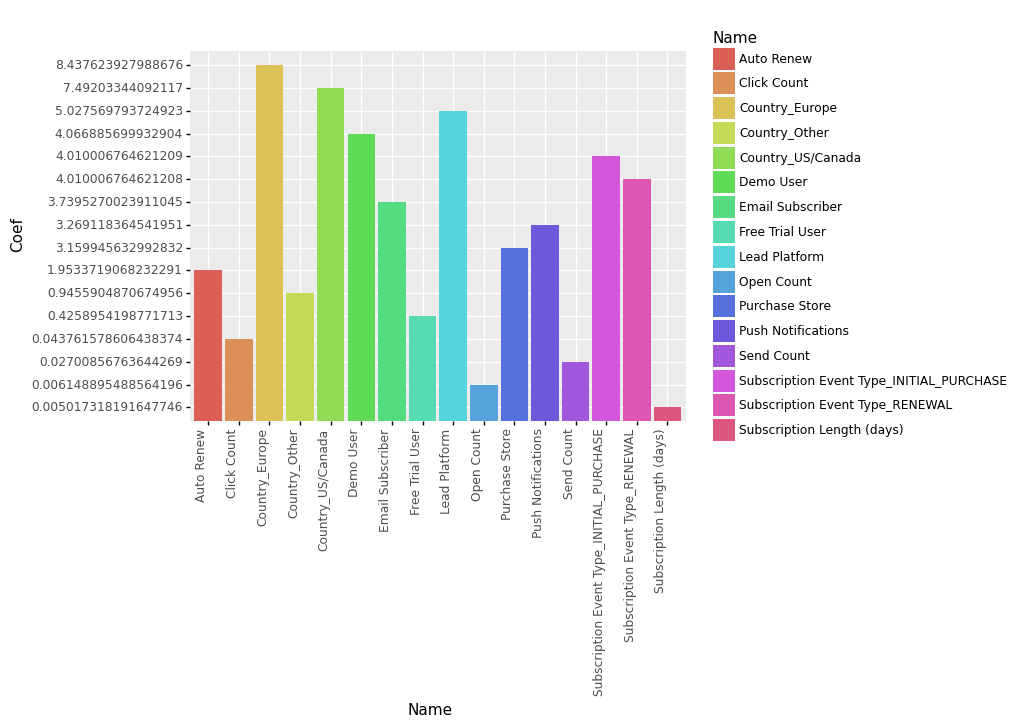

<ggplot: (8790339575589)>

In [596]:
coefficients['Coef'] = abs(coefficients['Coef'])

(ggplot(coefficients, aes(x = 'Name', y = 'Coef', fill = 'Name')) + 
 stat_summary(geom = "bar") +
 theme(axis_text_x=element_text(rotation=90, hjust=1)))

# Logistic Regression

In [597]:
predictors = ['Purchase Store', 'Demo User', 'Free Trial User', 'Auto Renew', 'Lead Platform', 
              'Email Subscriber', 'Push Notifications','Send Count', 'Open Count', 'Click Count',
              'Subscription Length (days)',
              'USDAdjusted','Country_Europe', 'Country_Other', 'Country_US/Canada']

x_train, x_test, y_train, y_test = train_test_split(df[predictors], df["Subscription Event Type_RENEWAL"], test_size = 0.2)

zScore = StandardScaler()
zScore.fit(x_train)

xz_train = zScore.transform(x_train)
xz_test = zScore.transform(x_test)

myLogit = LogisticRegression()

myLogit.fit(xz_train, y_train)

pred = myLogit.predict(xz_test)

accuracy_score(y_test, pred)

0.7478289913159653

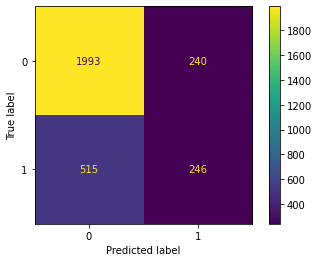

In [598]:
plot_confusion_matrix(myLogit, xz_test, y_test)

In [599]:
coef = pd.DataFrame({"Odds Coef": np.exp(myLogit.coef_[0]), "Name": predictors})
coef = coef.append({"Odds Coef": np.exp(myLogit.intercept_[0]), "Name": "Intercept"}, ignore_index = True)
coef

,Odds Coef,Name
0,1.025931,Purchase Store
1,0.887553,Demo User
2,0.727760,Free Trial User
3,1.450396,Auto Renew
4,0.954574,Lead Platform
5,1.004978,Email Subscriber
6,1.120967,Push Notifications
7,0.676578,Send Count
8,1.537045,Open Count
9,0.346845,Click Count


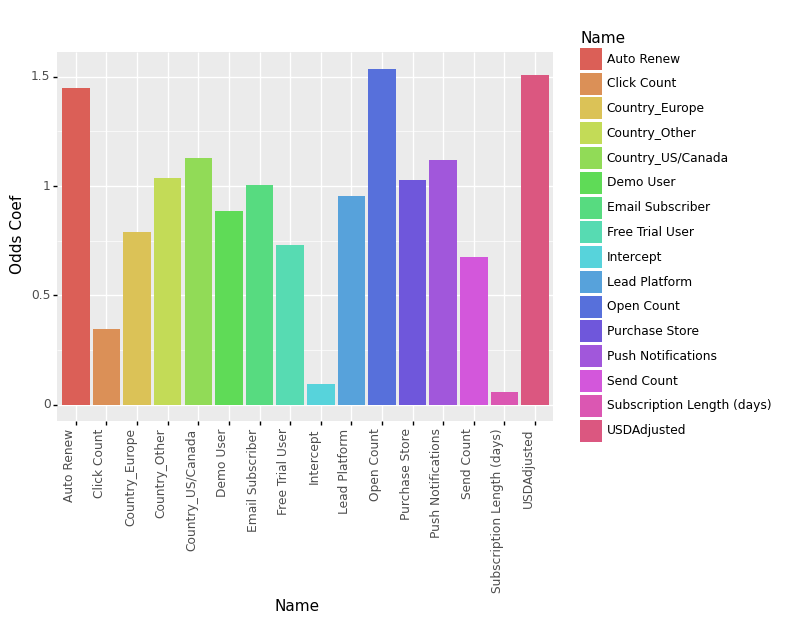

<ggplot: (8790074873438)>

In [600]:
coef['Odds Coef'] = abs(coef['Odds Coef'])

#visualization of coefficients
ggplot(coef, aes(x = 'Name', y = 'Odds Coef', fill = 'Name')) + stat_summary(geom = "bar") + theme(axis_text_x=element_text(rotation=90, hjust=1))


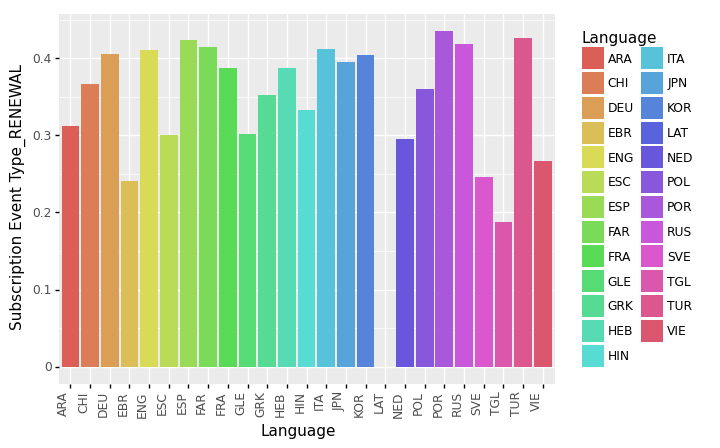

<ggplot: (8790401930993)>

In [601]:
l_df = df[df.Language != 'ALL']

ggplot(l_df, aes(x = 'Language', y = 'Subscription Event Type_RENEWAL', fill = 'Language')) + stat_summary(geom = "bar") + theme(axis_text_x=element_text(rotation=90, hjust=1))



# K Means Clustering

In [602]:
predictors = ['Purchase Store', 'Demo User', 'Free Trial User', 'Auto Renew', 'Lead Platform', 
              'Email Subscriber', 'Push Notifications','Send Count', 'Open Count', 'Click Count',
              'Subscription Length (days)', 'Subscription Event Type_INITIAL_PURCHASE',
              'Subscription Event Type_RENEWAL', 'Country_Europe', 'Country_Other', 'Country_US/Canada',
             'USDAdjusted']

k_df = df[predictors]

zScore = StandardScaler()
zScore.fit(k_df)

xz_train = zScore.transform(k_df)
xz_test = zScore.transform(k_df)

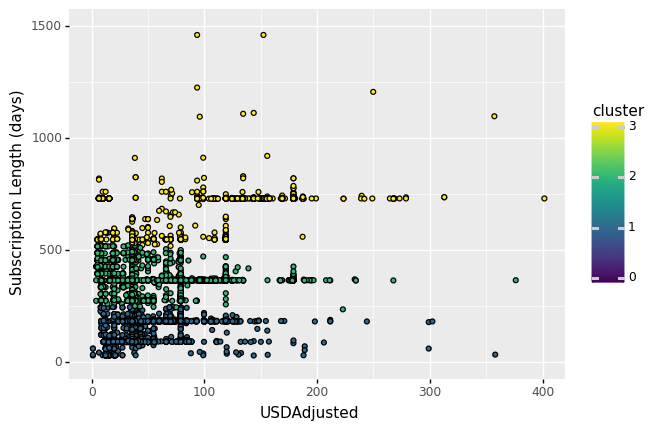

<ggplot: (8790399253345)>

In [603]:
km = KMeans(n_clusters = 4)
km.fit(k_df)

membership = km.predict(k_df)

k_df['cluster'] = membership

ggplot(k_df, aes(x = 'USDAdjusted', y = 'Subscription Length (days)', fill = 'cluster')) + geom_point() + coord_cartesian(xlim=(0, 400), ylim=(0, 1500)) 


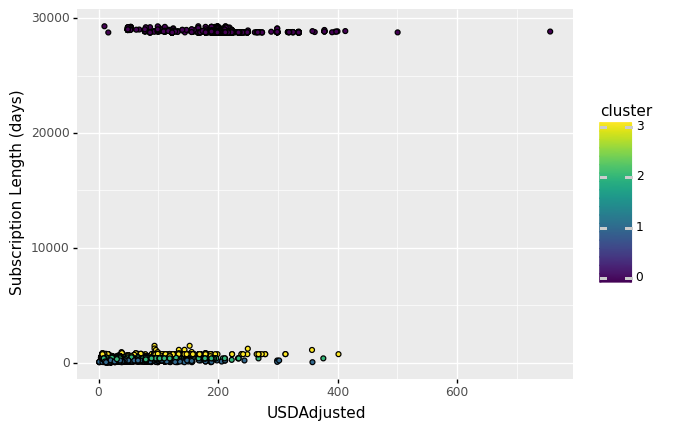

<ggplot: (8790356736269)>

In [605]:
ggplot(k_df, aes(x = 'USDAdjusted', y = 'Subscription Length (days)', fill = 'cluster')) + geom_point()


In [606]:
silhouette_score(k_df, membership) 

0.72243711934249

In [607]:
k_df

,Purchase Store,Demo User,Free Trial User,Auto Renew,Lead Platform,Email Subscriber,Push Notifications,Send Count,Open Count,Click Count,Subscription Length (days),Subscription Event Type_INITIAL_PURCHASE,Subscription Event Type_RENEWAL,Country_Europe,Country_Other,Country_US/Canada,USDAdjusted,cluster
1,0,0,0,0,0,0,1,4.0,3.0,0.0,92.0,1,0,0,1,0,39.000000,1
5,0,1,0,0,1,1,1,162.0,1.0,0.0,92.0,1,0,0,0,1,38.340000,1
6,0,1,0,0,1,1,1,2.0,0.0,0.0,113.0,0,1,0,1,0,79.000000,1
7,0,1,0,1,1,1,1,25.0,17.0,4.0,92.0,1,0,0,0,1,38.400000,1
8,0,0,1,1,0,0,1,52.0,11.0,0.0,97.0,1,0,1,0,0,43.160000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40092,0,0,0,1,0,0,0,16.0,10.0,0.0,92.0,1,0,0,1,0,35.970000,1
40093,0,0,0,1,0,0,0,4.0,0.0,0.0,183.0,0,1,0,1,0,35.970000,1
40094,0,0,0,0,0,1,1,40.0,0.0,0.0,31.0,1,0,1,0,0,12.394300,1
40095,0,0,0,0,0,0,0,6.0,2.0,0.0,28781.0,1,0,0,1,0,212.130000,0


In [ ]:
c1 = 0
c2 = 0
c3 = 0
c4 = 0

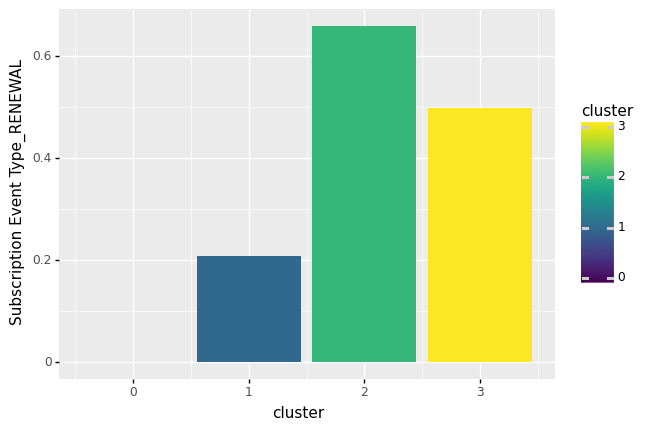

<ggplot: (8790397958226)>

In [616]:
ggplot(k_df, aes(x = 'cluster', y = 'Subscription Event Type_RENEWAL', fill = 'cluster')) + stat_summary(geom = "bar")

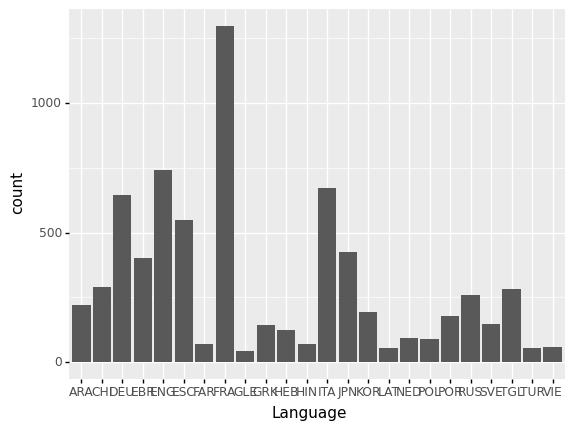

<ggplot: (8790378120250)>

In [648]:
k_df = k_df[df.Language != 'ALL']
k_df = k_df[df.Language != 'ESP']

ggplot(k_df, aes(x = 'Language', fill = 'cluster')) + geom_bar()

In [649]:
#Figure out if certain languages are more common in certain clusters
#Tagalog and Swedish should be more common in cluster 0 and 2